In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import random
import cv2
from IPython.display import HTML
import base64
import io
import os
import time  

In [2]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [3]:
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [4]:
# Hyperparameters
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 128
GAMMA = 0.99
TAU = 1e-3
LR = 5e-5
UPDATE_EVERY = 4
EPSILON_START = 1.00
EPSILON_END = 0.01
EPSILON_DECAY = 0.999
MIN_REPLAY_LENGTH = 1000
HARD_UPDATE = 1000
SOLVED_SCORE = 465.0





In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Experience tuple
Experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

Using device: cpu


/home/sans/Reinforcement-Learning/env/lib/python3.12/site-packages/torch/cuda/__init__.py:182: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [6]:
class DQN(nn.Module):
    """Deep Q-Network"""

    def __init__(self, state_size, action_size, hidden_size=128):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)  
        self.fc4 = nn.Linear(hidden_size, action_size)
        self._init_weights() 
   
    def _init_weights(self):
        """Initialize weights using Xavier initialization"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)


In [7]:

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples"""

    def __init__(self, buffer_size, batch_size):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        e = Experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [8]:
class TrackPerformance:
    def __init__(self):
        self.loss = []
        self.avg_q_values = []

    def track(self, loss, avg_q_value):
        self.loss.append(loss)
        self.avg_q_values.append(avg_q_value)



In [9]:
class DQNAgent:
    """Deep Q-Network Agent"""

    def __init__(self, state_size, action_size, lr=LR):
        self.state_size = state_size
        self.action_size = action_size

        # Q-Networks
        self.q_network_local = DQN(state_size, action_size).to(device)
        self.q_network_target = DQN(state_size, action_size).to(device)
        self.q_network_target.load_state_dict(self.q_network_local.state_dict())
        self.optimizer = optim.AdamW(self.q_network_local.parameters(), lr=lr, weight_decay=1e-5)


        # Replay memory
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)
        self.t_step = 0

        # Exploration parameters
        self.epsilon = EPSILON_START
        self.episode_q_means = []   # per-episode mean Q (avg over visited states)
        self.episode_q_maxs = []    # per-episode max Q
        self.episode_td_means = []  # per-episode avg TD error (aggregated from learns in episode)
        # self.performance_tracking = TrackPerformance()

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every HARD_UPDATE time steps
        self.t_step = (self.t_step + 1)
        if self.t_step % UPDATE_EVERY == 0:
            if len(self.memory) > MIN_REPLAY_LENGTH:
                experiences = self.memory.sample()
                return self.learn(experiences, GAMMA)
        return None



    def act(self, state, eps=None):
        """Returns actions for given state as per current policy"""
        if eps is None:
            eps = self.epsilon

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.q_network_local.eval()
        with torch.no_grad():
            action_values = self.q_network_local(state)
        self.q_network_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    # ----------------- 3) learn(): Double DQN, Huber loss, grad clip, TD tracking -----------------
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        # Double DQN: choose best next action with local net
        best_next_actions = self.q_network_local(next_states).argmax(dim=1, keepdim=True)
        # evaluate those actions with target net
        Q_targets_next = self.q_network_target(next_states).gather(1, best_next_actions).detach()

        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.q_network_local(states).gather(1, actions)

        # Huber loss
        loss = F.mse_loss(Q_expected, Q_targets)

        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.q_network_local.parameters(), 1.0)
        self.optimizer.step()

        # TD error (mean absolute)
        td_error = (Q_targets - Q_expected).detach().abs().mean().item()

        # target updates: use learn_step_count (not t_step)
        if self.t_step % HARD_UPDATE == 0:
            self.hard_update(self.q_network_local, self.q_network_target)
        else:
            self.soft_update(self.q_network_local, self.q_network_target, TAU)
    
        # return both loss and td for external tracking
        return loss.item(), td_error


    def hard_update(self, local_model, target_model):
        """Hard update model parameters"""
        target_model.load_state_dict(local_model.state_dict())

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters"""
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [10]:
def train_dqn(n_episodes=1000, max_t=1000, eps_start=EPSILON_START, eps_end=EPSILON_END, eps_decay=EPSILON_DECAY, reward_shaping=True):
    """
    Train the DQN agent.

    Returns:
        scores, agent, losses, episode_times, td_errors_per_episode, q_mean_per_episode, q_max_per_episode
    """
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)

    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start

    losses = []
    episode_times = []

    # New metric lists to return
    td_errors_per_episode = []
    q_mean_per_episode = []
    q_max_per_episode = []

    # ----------------- Warm-up: fill replay buffer -----------------
    if len(agent.memory) < MIN_REPLAY_LENGTH:
        print(f"Warming up replay buffer to {MIN_REPLAY_LENGTH} transitions...")
        while len(agent.memory) < MIN_REPLAY_LENGTH:
            s, _ = env.reset()
            done = False
            while not done and len(agent.memory) < MIN_REPLAY_LENGTH:
                a = env.action_space.sample()
                s_next, r, term, trunc, _ = env.step(a)
                done = term or trunc
                agent.memory.add(s, a, r, s_next, done)
                s = s_next
        print("Replay buffer warmed up.")

    # helper: estimate TD error using a sampled batch (Double DQN style)
    def estimate_td(agent, gamma=GAMMA):
        # If not enough samples, return 0
        if len(agent.memory) < agent.memory.batch_size:
            return 0.0
        states_b, actions_b, rewards_b, next_states_b, dones_b = agent.memory.sample()
        with torch.no_grad():
            # choose best actions by local network
            best_next_actions = agent.q_network_local(next_states_b).argmax(dim=1, keepdim=True)
            q_next = agent.q_network_target(next_states_b).gather(1, best_next_actions)
            q_target = rewards_b + gamma * q_next * (1 - dones_b)
            q_expected = agent.q_network_local(states_b).gather(1, actions_b)
            td = (q_target - q_expected).abs().mean().item()
        return td

    # ----------------- Training loop -----------------
    for i_episode in range(1, n_episodes + 1):
        start_time = time.time()
        state, _ = env.reset()
        score = 0.0

        total_loss = 0.0
        loss_count = 0

        # per-episode containers for metrics
        q_vals_this_episode = []
        td_vals_this_episode = []
        losses_this_episode = []

        for t in range(max_t):
            # compute Q-values for diagnostics (local network)
            with torch.no_grad():
                s_t = torch.from_numpy(state).float().unsqueeze(0).to(device)
                qvals = agent.q_network_local(s_t).cpu().numpy().flatten()
                q_vals_this_episode.append(float(qvals.mean()))
                # keep max as well if you want per-step max
                # store per-step max in separate list by taking np.max(qvals) if needed

            # select action
            action = agent.act(state, eps)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # optional reward shaping (keep original env reward by default)
            if reward_shaping:
                if not done:
                    r = 1.0
                else:
                    r = -10.0 if t < (max_t - 1) else 1.0
            else:
                r = reward

            # call agent.step (this may perform learning)
            out = agent.step(state, action, r, next_state, done)

            # Determine if a learning update happened: same condition used by agent.step()
            # agent.step increases agent.t_step every env step, and runs learn only when:
            # (agent.t_step % UPDATE_EVERY == 0) and (len(agent.memory) > MIN_REPLAY_LENGTH)
            if (agent.t_step % UPDATE_EVERY == 0) and (len(agent.memory) > MIN_REPLAY_LENGTH):
                # out is expected to be the scalar loss returned by your current learn()
                # but be defensive: handle tuple or None as well
                if out is None:
                    # no loss returned; skip
                    pass
                else:
                    if isinstance(out, (tuple, list)):
                        loss_val = float(out[0]) if out[0] is not None else None
                    else:
                        # your implementation earlier returned a scalar loss
                        loss_val = float(out)

                    if loss_val is not None:
                        losses_this_episode.append(loss_val)
                        total_loss += loss_val
                        loss_count += 1

                # estimate TD on a fresh batch (no change to agent.learn)
                td_est = estimate_td(agent)
                td_vals_this_episode.append(td_est)

            state = next_state
            score += reward

            if done:
                break

        end_time = time.time()

        # aggregate per-episode metrics
        avg_loss = float(np.mean(losses_this_episode)) if losses_this_episode else 0.0
        losses.append(avg_loss)
        episode_times.append(end_time - start_time)

        scores_window.append(score)
        scores.append(score)

        # aggregate per-episode Q metrics
        q_mean_ep = float(np.mean(q_vals_this_episode)) if q_vals_this_episode else 0.0
        q_max_ep = float(np.max(q_vals_this_episode)) if q_vals_this_episode else 0.0
        td_mean_ep = float(np.mean(td_vals_this_episode)) if td_vals_this_episode else 0.0

        q_mean_per_episode.append(q_mean_ep)
        q_max_per_episode.append(q_max_ep)
        td_errors_per_episode.append(td_mean_ep)

        # epsilon decay (keeps your previous behavior: start decaying after some episodes)
        if i_episode > 200:
            eps = max(eps_end, eps_decay * eps)

        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}\tEpsilon: {eps:.3f}', end="")

        if i_episode % 100 == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}')

        # solved condition (note: this corresponds to original env reward scale)
        if np.mean(scores_window) >= SOLVED_SCORE:
            print(f'\nEnvironment solved in {i_episode-100:d} episodes!\tAverage Score: {np.mean(scores_window):.2f}')
            torch.save(agent.q_network_local.state_dict(), 'checkpoint.pth')
            break

    torch.save(agent.q_network_local.state_dict(), 'checkpoint.pth')
    env.close()

    return scores, agent, losses, episode_times, td_errors_per_episode, q_mean_per_episode, q_max_per_episode


In [11]:
def plot_training_results(scores, losses=None, episode_times=None, td_errors=None, q_means=None, q_maxs=None):
    """Plot training results including TD-errors and Q-value metrics."""
    fig, axs = plt.subplots(3, 2, figsize=(15, 10))

    # Raw scores
    axs[0, 0].plot(np.arange(len(scores)), scores)
    axs[0, 0].set_ylabel('Score')
    axs[0, 0].set_xlabel('Episode #')
    axs[0, 0].set_title('Training Scores')
    axs[0, 0].grid(True, alpha=0.3)

    # Rolling average score
    rolling_mean = []
    window_size = 100
    for i in range(len(scores)):
        start_idx = max(0, i - window_size + 1)
        rolling_mean.append(np.mean(scores[start_idx:i+1]))

    # use SOLVED_SCORE if defined else fallback to 195
    solved_y = globals().get("SOLVED_SCORE", 195)
    axs[0, 1].plot(np.arange(len(rolling_mean)), rolling_mean, color='red')
    axs[0, 1].axhline(y=solved_y, color='green', linestyle='--', alpha=0.7, label='Solved threshold')
    axs[0, 1].set_ylabel('Average Score')
    axs[0, 1].set_xlabel('Episode #')
    axs[0, 1].set_title('Rolling Average Score (100 episodes)')
    axs[0, 1].legend()
    axs[0, 1].grid(True, alpha=0.3)

    # Loss plot
    if losses:
        axs[1, 0].plot(np.arange(len(losses)), losses, color='orange')
        axs[1, 0].set_title('Average Loss per Episode')
        axs[1, 0].set_xlabel('Episode #')
        axs[1, 0].set_ylabel('Loss')
        axs[1, 0].grid(True, alpha=0.3)
    else:
        axs[1, 0].axis('off')

    # Timing plot
    if episode_times:
        avg_times = []
        for i in range(len(episode_times)):
            start_idx = max(0, i - 99)
            avg_times.append(np.mean(episode_times[start_idx:i+1]))

        axs[1, 1].plot(np.arange(len(avg_times)), avg_times, color='purple')
        axs[1, 1].set_title('Average Training Time per Episode (Rolling 100)')
        axs[1, 1].set_xlabel('Episode #')
        axs[1, 1].set_ylabel('Time (s)')
        axs[1, 1].grid(True, alpha=0.3)
    else:
        axs[1, 1].axis('off')

    # TD error plot (bottom-left)
    if td_errors:
        axs[2, 0].plot(np.arange(len(td_errors)), td_errors, color='blue')
        axs[2, 0].set_title('Per-episode mean TD error')
        axs[2, 0].set_xlabel('Episode #')
        axs[2, 0].set_ylabel('Mean |TD|')
        axs[2, 0].grid(True, alpha=0.3)
    else:
        axs[2, 0].axis('off')

    # Q metrics (bottom-right): mean and max Q (per-episode)
    if (q_means is not None) and (q_maxs is not None):
        axs[2, 1].plot(np.arange(len(q_means)), q_means, label='mean Q')
        axs[2, 1].plot(np.arange(len(q_maxs)), q_maxs, label='max Q', alpha=0.8)
        axs[2, 1].set_title('Per-episode Q metrics')
        axs[2, 1].set_xlabel('Episode #')
        axs[2, 1].set_ylabel('Q value')
        axs[2, 1].legend()
        axs[2, 1].grid(True, alpha=0.3)
    else:
        axs[2, 1].axis('off')

    plt.tight_layout()
    plt.show()


Starting DQN Training for CartPole...
Warming up replay buffer to 1000 transitions...
Replay buffer warmed up.
Episode 100	Average Score: 21.81	Epsilon: 1.000
Episode 200	Average Score: 22.02	Epsilon: 1.000
Episode 300	Average Score: 24.75	Epsilon: 0.905
Episode 400	Average Score: 35.06	Epsilon: 0.819
Episode 500	Average Score: 39.06	Epsilon: 0.741
Episode 600	Average Score: 53.03	Epsilon: 0.670
Episode 700	Average Score: 73.94	Epsilon: 0.606
Episode 800	Average Score: 93.96	Epsilon: 0.549
Episode 900	Average Score: 109.16	Epsilon: 0.496
Episode 1000	Average Score: 157.36	Epsilon: 0.449
Episode 1100	Average Score: 184.93	Epsilon: 0.406
Episode 1200	Average Score: 187.75	Epsilon: 0.368
Episode 1300	Average Score: 212.16	Epsilon: 0.333
Episode 1400	Average Score: 198.11	Epsilon: 0.301
Episode 1500	Average Score: 187.91	Epsilon: 0.272
Episode 1600	Average Score: 209.51	Epsilon: 0.246
Episode 1700	Average Score: 279.05	Epsilon: 0.223
Episode 1800	Average Score: 270.38	Epsilon: 0.202
Episod

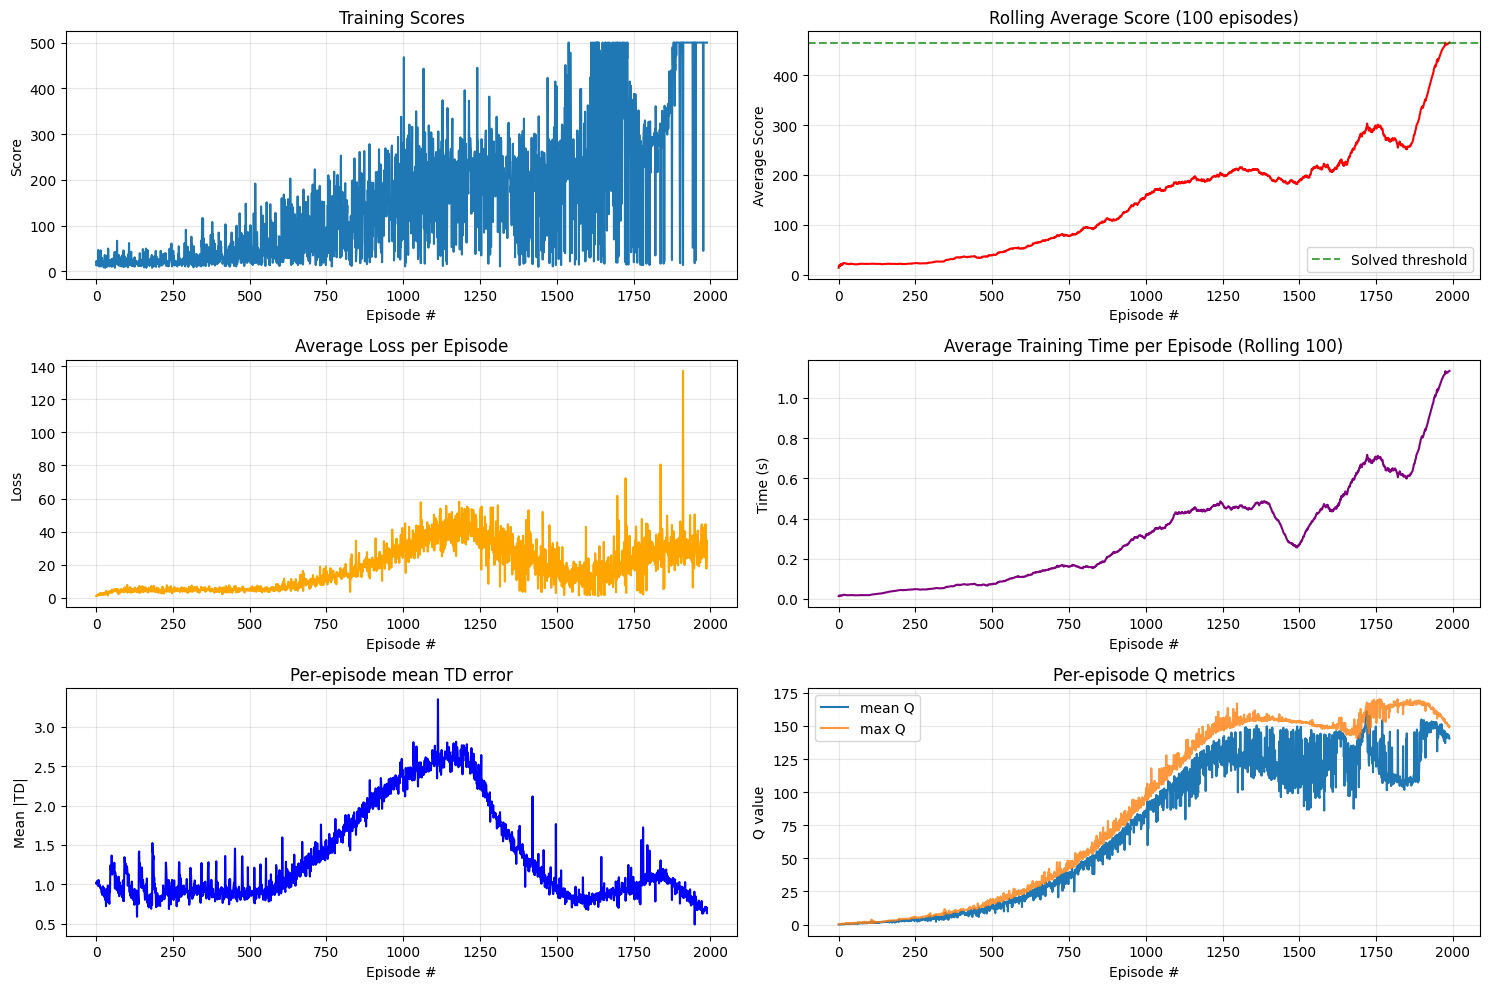

In [12]:
# Main execution
if __name__ == "__main__":
    print("Starting DQN Training for CartPole...")
    print("="*50)

    # train_dqn now returns: scores, agent, losses, episode_times, td_errors_per_episode, q_mean_per_episode, q_max_per_episode
    scores, trained_agent, losses, episode_times, td_errors, q_means, q_maxs = train_dqn(
        n_episodes=5000, eps_decay=EPSILON_DECAY, eps_end=EPSILON_END
    )

    print(f"Max score: {max(scores)}")

    print("\nPlotting training results...")
    plot_training_results(scores, losses, episode_times, td_errors, q_means, q_maxs)


In [ ]:

# Additional utility functions for deeper analysis
def plot_q_values(agent, state_samples=None):
    """Visualize Q-values for different states"""
    if state_samples is None:
        # Create some sample states
        state_samples = np.array([
            [0.0, 0.0, 0.0, 0.0],    # Balanced
            [0.1, 0.0, 0.1, 0.0],    # Slightly right
            [-0.1, 0.0, -0.1, 0.0],  # Slightly left
            [0.0, 0.0, 0.2, 0.0],    # Pole leaning right
            [0.0, 0.0, -0.2, 0.0],   # Pole leaning left
        ])

    agent.q_network_local.eval()
    with torch.no_grad():
        states_tensor = torch.FloatTensor(state_samples).to(device)
        q_values = agent.q_network_local(states_tensor).cpu().numpy()

    fig, ax = plt.subplots(figsize=(10, 6))

    x = np.arange(len(state_samples))
    width = 0.35

    ax.bar(x - width/2, q_values[:, 0], width, label='Left', alpha=0.7)
    ax.bar(x + width/2, q_values[:, 1], width, label='Right', alpha=0.7)

    ax.set_xlabel('State Samples')
    ax.set_ylabel('Q-Values')
    ax.set_title('Q-Values for Different States')
    ax.set_xticks(x)
    ax.set_xticklabels([f'State {i+1}' for i in range(len(state_samples))])
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return q_values
